# Aprendizado por reforço

### Bibliotecas básicas

In [1]:
import numpy as np
import pandas as pd
from functools import partial

%matplotlib nbagg
import matplotlib
import matplotlib.animation as animation
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import warnings
warnings.filterwarnings('ignore')

import gym

import tensorflow as tf
print(tf.__version__)

2.4.1


In [2]:
tf.compat.v1.disable_eager_execution()

### Introdução OpenAI gym

In [3]:
env = gym.make('MsPacman-v0')
observacao = env.reset()
print(observacao.shape, '\n')
img = env.render(mode='rgb_array')

(210, 160, 3) 



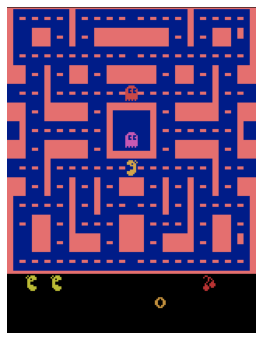

In [4]:
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.show()

#### Função auxiliar para traçar um ambiente

In [5]:
def plot_environment(env, figsize=(10, 6)):
    plt.close()
    plt.figure(figsize=figsize)
    img = env.render(mode='rgb_array')
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [6]:
print(f'Espaço de ação: {env.action_space}')

Espaço de ação: Discrete(9)


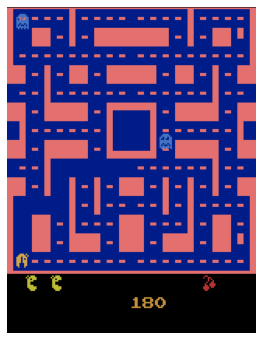

In [7]:
env.reset()
for step in range(110):
    env.step(3) #esquerda
for step in range(40):
    env.step(8) #inferior esquerda
    
plot_environment(env)

In [8]:
obs, reward, done, info = env.step(0)

A observação diz ao agente como é o ambiente:

In [9]:
obs.shape

(210, 160, 3)

O ambiente também informa ao agente quanta recompensa ele obteve durante a última etapa:

In [10]:
reward

0.0

Quando o jogo acaba, o ambiente retorna **done=True**:

In [11]:
done

False

O info é um dicionário específico do ambiente que pode fornecer algumas informações extras sobre o estado interno do ambiente. Isso é útil para depuração, mas seu agente não deve usar essas informações para aprendizado (seria trapaça).

In [12]:
info

{'ale.lives': 3}

#### Jogo completo com 3 vidas, movendo-nos em direções aleatórias por 10 etapas de cada vez, gravando cada quadro

In [13]:
def update_scene(num, frames, patch):
    patch.set_data(frames[num])
    return patch,

def plot_animation(frames, repeat=False, interval=40):
    plt.close()
    fig = plt.figure()
    patch = plt.imshow(frames[0])
    plt.axis('off')
    return animation.FuncAnimation(fig, update_scene, fargs=(frames, patch), frames=len(frames), repeat=repeat, interval=interval)

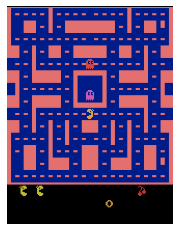

In [14]:
frames = []

n_max_steps = 1000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
    img = env.render(mode='rgb_array')
    frames.append(img)
    if step % n_change_steps == 0:
        action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    if done:
        break


video = plot_animation(frames)
plt.show()

In [15]:
env.close()

### Um ambiente simples: the Cart-Pole

In [16]:
env = gym.make('CartPole-v0')
obs = env.reset()
obs

array([-0.01502732, -0.0013621 , -0.03599252, -0.0211515 ])

#### Corrigindo o problema de renderização

In [17]:
from PIL import Image, ImageDraw

try:
    from pyglet.gl import gl_info
    openai_cart_pole_rendering = True
except Exception:
    openai_cart_pole_rendering = False

def render_cart_pole(env, obs):
    if openai_cart_pole_rendering:
        # use OpenAI gym's rendering function
        return env.render(mode='rgb_array')
    else:
        # rendering for the cart pole environment (in case OpenAI gym can't do it)
        img_w = 600
        img_h = 400
        cart_w = img_w // 12
        cart_h = img_h // 15
        pole_len = img_h // 3.5
        pole_w = img_w // 80 + 1
        x_width = 2
        max_ang = 0.2
        bg_col = (255, 255, 255)
        cart_col = 0x000000 # Blue Green Red
        pole_col = 0x669acc # Blue Green Red

        pos, vel, ang, ang_vel = obs
        img = Image.new('RGB', (img_w, img_h), bg_col)
        draw = ImageDraw.Draw(img)
        cart_x = pos * img_w // x_width + img_w // x_width
        cart_y = img_h * 95 // 100
        top_pole_x = cart_x + pole_len * np.sin(ang)
        top_pole_y = cart_y - cart_h // 2 - pole_len * np.cos(ang)
        draw.line((0, cart_y, img_w, cart_y), fill=0)
        draw.rectangle((cart_x - cart_w // 2, cart_y - cart_h // 2, cart_x + cart_w // 2, cart_y + cart_h // 2), fill=cart_col) # draw cart
        draw.line((cart_x, cart_y - cart_h // 2, top_pole_x, top_pole_y), fill=pole_col, width=pole_w) # draw pole
        return np.array(img)

def plot_cart_pole(env, obs):
    plt.close()  # or else nbagg sometimes plots in the previous cell
    img = render_cart_pole(env, obs)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

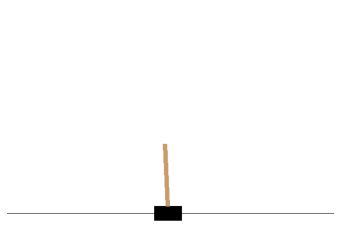

In [18]:
plot_cart_pole(env, obs)

In [19]:
print(f'Espaço de ação: {env.action_space}')

Espaço de ação: Discrete(2)


Empurrando o carrinho

(-0.5, 599.5, 399.5, -0.5)

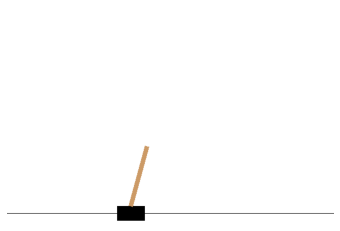

In [20]:
obs = env.reset()
while True:
    obs, reward, done, info = env.step(0)
    if done:
        break

plt.close()
img = render_cart_pole(env, obs)
plt.imshow(img)
plt.axis('off')

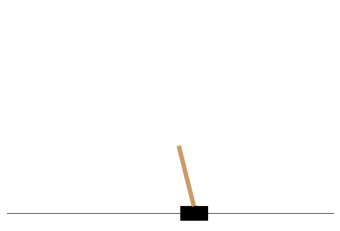

In [21]:
obs = env.reset()
while True:
    obs, reward, done, info = env.step(1)
    if done:
        break

plot_cart_pole(env, obs)

Definindo uma política

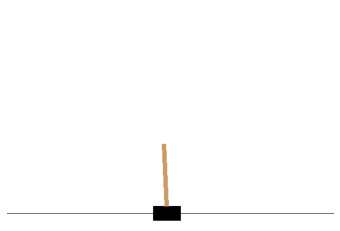

In [22]:
frames = []

n_max_steps = 1000
n_change_steps = 10

obs = env.reset()
for step in range(n_max_steps):
    img = render_cart_pole(env, obs)
    frames.append(img)

    # hard-coded policy
    position, velocity, angle, angular_velocity = obs
    if angle < 0:
        action = 0
    else:
        action = 1

    obs, reward, done, info = env.step(action)
    if done:
        break

video = plot_animation(frames)
plt.show()

### Políticas de rede neural

In [26]:
n_inputs = env.observation_space.shape[0]
n_hidden = 4
n_outputs = 1

initializer = tf.compat.v1.variance_scaling_initializer()


X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.compat.v1.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
outputs = tf.compat.v1.layers.dense(hidden, n_outputs, activation=tf.nn.sigmoid, kernel_initializer=initializer)

p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.compat.v1.multinomial(tf.math.log(p_left_and_right), num_samples=1)

init = tf.compat.v1.global_variables_initializer()


n_max_steps = 1000
frames = []

with tf.compat.v1.Session() as sess:
    init.run()
    obs = env.reset()
    for step in range(n_max_steps):
        img = render_cart_pole(env, obs)
        frames.append(img)
        action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
        obs, reward, done, info = env.step(action_val[0][0])
        if done:
            break

env.close()


video = plot_animation(frames)
plt.show()

### Política de gradiente

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [51]:
n_inputs = 4
n_hidden = 4
n_outputs = 1
learning_rate = 0.01

initializer = tf.compat.v1.variance_scaling_initializer()


X = tf.compat.v1.placeholder(tf.float32, shape=[None, n_inputs])
hidden = tf.compat.v1.layers.dense(X, n_hidden, activation=tf.nn.elu, kernel_initializer=initializer)
logits = tf.compat.v1.layers.dense(hidden, n_outputs)
outputs = tf.compat.v1.nn.sigmoid(logits)

p_left_and_right = tf.concat(axis=1, values=[outputs, 1 - outputs])
action = tf.compat.v1.multinomial(tf.math.log(p_left_and_right), num_samples=1)

init = tf.compat.v1.global_variables_initializer()

y = 1. - tf.compat.v1.to_float(action)
cross_entropy = tf.compat.v1.nn.sigmoid_cross_entropy_with_logits(labels=y, logits=logits)
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)

In [53]:
grads_and_vars = optimizer.compute_gradients(cross_entropy)
gradients = [grad for grad, variable in grads_and_vars if grad != None]

gradient_placeholders = []
grads_and_vars_feed = []
for grad, variable in grads_and_vars:
  if grad != None:
    gradient_placeholder = tf.compat.v1.placeholder(tf.float32, shape=grad.get_shape())
    gradient_placeholders.append(gradient_placeholder)
    grads_and_vars_feed.append((gradient_placeholder, variable))

training_op = optimizer.apply_gradients(grads_and_vars_feed)
init = tf.compat.v1.global_variables_initializer()
saver = tf.compat.v1.train.Saver()

In [54]:
def discount_rewards(rewards, discount_rate):
    discounted_rewards = np.zeros(len(rewards))
    cumulative_rewards = 0
    for step in reversed(range(len(rewards))):
        cumulative_rewards = rewards[step] + cumulative_rewards * discount_rate
        discounted_rewards[step] = cumulative_rewards
    return discounted_rewards

def discount_and_normalize_rewards(all_rewards, discount_rate):
    all_discounted_rewards = [discount_rewards(rewards, discount_rate) for rewards in all_rewards]
    flat_rewards = np.concatenate(all_discounted_rewards)
    reward_mean = flat_rewards.mean()
    reward_std = flat_rewards.std()
    return [(discounted_rewards - reward_mean)/reward_std for discounted_rewards in all_discounted_rewards]

In [55]:
env = gym.make('CartPole-v0')

n_games_per_update = 10
n_max_steps = 1000
n_iterations = 250
save_iterations = 10
discount_rate = 0.95

with tf.compat.v1.Session() as sess:
    init.run()
    for iteration in range(n_iterations):
        print('\rIteration: {}'.format(iteration), end='')
        all_rewards = []
        all_gradients = []
        for game in range(n_games_per_update):
            current_rewards = []
            current_gradients = []
            obs = env.reset()
            for step in range(n_max_steps):
                action_val, gradients_val = sess.run([action, gradients], feed_dict={X: obs.reshape(1, n_inputs)})
                obs, reward, done, info = env.step(action_val[0][0])
                current_rewards.append(reward)
                current_gradients.append(gradients_val)
                if done:
                    break
            all_rewards.append(current_rewards)
            all_gradients.append(current_gradients)

        all_rewards = discount_and_normalize_rewards(all_rewards, discount_rate=discount_rate)
        feed_dict = {}
        for var_index, gradient_placeholder in enumerate(gradient_placeholders):
            mean_gradients = np.mean([reward * all_gradients[game_index][step][var_index]
                                      for game_index, rewards in enumerate(all_rewards)
                                          for step, reward in enumerate(rewards)], axis=0)
            feed_dict[gradient_placeholder] = mean_gradients
        sess.run(training_op, feed_dict=feed_dict)
        if iteration % save_iterations == 0:
            saver.save(sess, '/content/drive/MyDrive/Colab Notebooks/my_policy_net_pg.ckpt')

env.close()

Iteration: 249

In [60]:
def render_policy_net(model_path, action, X, n_max_steps = 1000):
    frames = []
    env = gym.make('CartPole-v0')
    obs = env.reset()
    with tf.compat.v1.Session() as sess:
        saver.restore(sess, model_path)
        for step in range(n_max_steps):
            img = render_cart_pole(env, obs)
            frames.append(img)
            action_val = action.eval(feed_dict={X: obs.reshape(1, n_inputs)})
            obs, reward, done, info = env.step(action_val[0][0])
            if done:
                break
    env.close()
    return frames

INFO:tensorflow:Restoring parameters from /content/drive/MyDrive/Colab Notebooks/my_policy_net_pg.ckpt


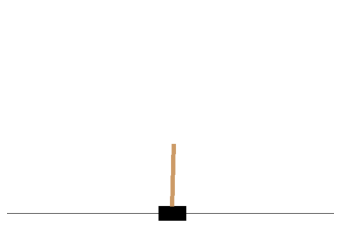

In [62]:
frames = render_policy_net('/content/drive/MyDrive/Colab Notebooks/my_policy_net_pg.ckpt', action, X, n_max_steps=1000)
video = plot_animation(frames)
plt.show()

### Cadeias de Markov